In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import gsw

In [2]:
def State(Hs):
    #/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/state_
    #file = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg500/state_' + str(format(Hs,'03d')) + '.nc')
    file = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/Qsg500n/state_' + str(format(Hs,'03d')) + '.nc')
#     t0 = 89
#     tn = 121
#     state = file.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(t0,tn))
    t0 = 10
    tn = 21
    state = file.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,41), T=range(t0,tn))
    X = state.X.data 
    x_dist = X / 1000
    depth = state.Z.data
    pres = gsw.p_from_z(depth, 55)
    pt = state.Temp.data.mean(axis=(0,2)) # Y-axis average
    s = state.S.data.mean(axis=(0,2))
    p = np.tile(pres,[len(X),1]).T
    rho = gsw.rho(s, pt, p)
    
    u0 = state.U.data # dims = T, Z, Y, Xp1
    u_ymean = (u0[:, :, :, 1:].mean(2) + u0[:, :, :, :-1].mean(2)) / 2
    u = u_ymean.mean(0) # dims = Z, X
    u[u==0] = np.nan
    
#     pt0 = file.Temp.data.mean(2)[1,:,:120]
    pt0 = file.Temp.data.mean(2)[1,:,:260]
    mask = (pt0 == 0)
    pt[mask] = np.nan
    s[mask] = np.nan
    rho[mask] = np.nan
    
    h1 = np.empty(len(X)-2)
    z_th = np.empty(len(X)-2)
    for i in range(1,len(X)-1):
        l = np.where(u[:, i] < 0)[-1][0] - 1
        #z_th[i-1] =  w[l, i] * pt[l, i]
        #h1[i-1] = -depth[l]
        # Calculate layer depth
#         if l <= 9:
#             h1[i-1] = -depth[l]+0.25
#         elif l <= 19:
#             h1[i-1] = -depth[l]+0.5
#         elif l <= 29:
#             h1[i-1] = -depth[l]+0.75
#         elif l <= 39:
#             h1[i-1] = -depth[l]+2
#         elif l <= 49:
#             h1[i-1] = -depth[l]+4
        
        if l <= 19:
            h1[i-1] = -depth[l]+1
        elif l <= 49:
            h1[i-1] = -depth[l]+2
        elif l <= 89:
            h1[i-1] = -depth[l]+3
    
    return (x_dist, depth, pt, rho, h1)

In [3]:
def IFA(Hs):
    # Grid areas
#     Area = np.empty([50, 9])
#     Area[:10,:] = 100
#     Area[10:20,:] = 200
#     Area[20:30,:] = 300
#     Area[30:40,:] = 800
#     Area[40:,:] = 1600
#     file = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg500/icefrntA_' + str(format(Hs,'03d')) + '.nc')
#     t0 = 89
#     tn = len(file.T)
#     state = file.isel(Y=range(30,39), T=range(t0,tn))
    
    Area = np.empty([90, 10])
    Area[:20,:] = 400
    Area[20:50,:] = 800
    Area[50:,:] = 1200

    file = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/Qsg500n/icefrntA_' + str(format(Hs,'03d')) + '.nc')
    t0 = 10
    tn = 21
    state = file.isel(Y=range(35,45), T=range(t0,tn))
    
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

In [ ]:
Hs = np.array([9, 15, 30, 150])

Qsm = np.empty(len(Hs))
for i in range(len(Hs)):
    Qsm[i] = IFA(Hs[i])
    
x1, z1, pt1, rho1, h1 = State(Hs[0])
x2, z2, pt2, rho2, h2 = State(Hs[1])
x3, z3, pt3, rho3, h3 = State(Hs[2])
x4, z4, pt4, rho4, h4 = State(Hs[3])
#Qsm1 = IFA(Hs[0])
#Qsm2 = IFA(Hs[1])
#Qsm3 = IFA(Hs[2])
#Qsm4 = IFA(Hs[3])

gridsize = (4, 5)
fig = plt.figure(figsize=(14, 12))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=4)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=4)
ax3 = plt.subplot2grid(gridsize, (2, 0), colspan=4)
ax4 = plt.subplot2grid(gridsize, (3, 0), colspan=4)
ax5 = plt.subplot2grid(gridsize, (0, 4), colspan=1, rowspan=4)
fig.tight_layout()

ct = np.linspace(-3,0,15) # Contour range for temperature
cmap = 'YlGnBu_r'


im1 = ax1.contourf(x1,z1[:24],pt1[:24,:]-9, ct, cmap=cmap)
#current_cmap = matplotlib.cm.get_cmap()
#cmap.set_bad('red',1.)
ax1.xaxis.set_visible(False)
ax1.annotate(text='', xy=(0.635,0.55), xycoords='axes fraction', xytext=(0.635,1), textcoords='axes fraction',arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.5})
ax1.set_xlim([x1[1],x1[-1]])
ax1.set_facecolor('k')
#ax1.fill_between([x1[0], x1[1]], z1[0], z1[23])

cbaxes = fig.add_axes([0.6, 1.01, 0.15, 0.01])
cbar = fig.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([-3, -2, -1, 0])
cbar.ax.set_title('Temperature Anomaly (\N{DEGREE SIGN}C)', size=10, weight='bold')
# Plot isopycnals
CS1 = ax1.contour(x1,z1[:24],rho1[:24,:],np.linspace(1012.5,1020.5,9), colors = 'gray')
plt.clabel(CS1, fmt='%1.1f', fontsize=15, inline=1)
ax1.plot(x1[1:-1],-h1, '--w', lw=2)
ax1.set_ylabel('Depth (m)', size=15)
ax1.tick_params(labelsize=12)
ax1.set_title('(a) $\mathregular{h_s}$ = ' + str(Hs[0]) + ' m', loc='left', size=15, weight='bold')

im2 = ax2.contourf(x2,z2[:24],pt2[:24,:]-9, ct, cmap=cmap)
ax2.xaxis.set_visible(False)
ax2.annotate(text='', xy=(0.635,0.4), xycoords='axes fraction', xytext=(0.635,1), textcoords='axes fraction', arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.5})
#fig.colorbar(im2,ax=ax2)
CS2 = ax2.contour(x2,z2[:24],rho2[:24,:],np.linspace(1012.5,1020.5,9), colors = 'gray')
plt.clabel(CS2, fmt='%1.1f', fontsize=15, inline=1)
ax2.plot(x2[1:-1],-h2, '--w', lw=2)
ax2.set_ylabel('Depth (m)', size=15)
ax2.tick_params(labelsize=12)
ax2.set_title('(b) $\mathregular{h_s}$ = ' + str(Hs[1]) + ' m', loc='left', size=15, weight='bold')
ax2.set_xlim([x2[1],x2[-1]])
ax2.set_facecolor('k')

im3 = ax3.contourf(x3,z3[:24],pt3[:24,:]-9, ct, cmap=cmap)
ax3.xaxis.set_visible(False)
ax3.annotate(text='', xy=(0.635,0.25), xycoords='axes fraction', xytext=(0.635,1), textcoords='axes fraction', arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.5})
#fig.colorbar(im3,ax=ax3)
CS3 = ax3.contour(x3,z3[:24],rho3[:24,:],np.linspace(1012.5,1020.5,9), colors = 'gray')
plt.clabel(CS3, fmt='%1.1f', fontsize=15, inline=1)
ax3.plot(x3[1:-1],-h3, '--w', lw=2)
ax3.set_ylabel('Depth (m)', size=15)
ax3.tick_params(labelsize=12)
ax3.set_title('(c) $\mathregular{h_s}$ = ' + str(Hs[2]) + ' m', loc='left', size=15, weight='bold')
ax3.set_xlim([x3[1],x3[-1]])
ax3.set_facecolor('k')

im4 = ax4.contourf(x4,z4[:24],pt4[:24,:]-9, ct, cmap=cmap)
ax4.annotate(text='', xy=(0.635,0), xycoords='axes fraction', xytext=(0.635,1), textcoords='axes fraction', arrowprops={'arrowstyle': '<|-','color':'red','linewidth':4,'alpha':0.5})
#fig.colorbar(im4,ax=ax4)
CS4 = ax4.contour(x4,z4[:24],rho4[:24,:],np.linspace(1012.5,1020.5,9), colors = 'gray')
plt.clabel(CS4, fmt='%1.1f', fontsize=15, inline=1)
ax4.plot(x4[1:-1],-h4, '--w', lw=2)

ax4.set_ylabel('Depth (m)', size=15)
#ax4.set_xlim([0,10])
ax4.set_xlim([x4[1],x4[-1]])
ax4.set_facecolor('k')
ax4.set_xticks([x4[1], 2, 4, 6, 8, x4[-1]])
ax4.set_xticklabels(["0","2","4","6","8","9"], size=15)

ax4.set_xlabel('Distance from glacier (km)', size=15)
ax4.tick_params(labelsize=12)
ax4.set_title('(d) $\mathregular{h_s}$ = ' + str(Hs[3]) + ' m', loc='left', size=15, weight='bold')

ax5.plot(Qsm,[1,2,3,4],'o-',lw=3)
ax5.grid(linestyle=':')
ax5.invert_yaxis()
#ax5.set_ylabel('Hs (m)', size=15)
ax5.tick_params(labelsize=12)

ax5.set_yticks([1, 2, 3, 4])
ax5.set_yticklabels(['$\mathregular{h_s}$=\n9m','$\mathregular{h_s}$=\n12m','$\mathregular{h_s}$=\n15m','$\mathregular{h_s}$=\n150m'], size=15)
#$\mathregular{N_i}$
ax5.set_xlabel(r'$\mathregular{Q_{sm}}\;(m^3/s)$', size=15, weight='bold')
ax5.xaxis.set_label_position('top')
ax5.xaxis.set_ticks_position('top') # this moves the ticks to the top
ax5.set_title('(e)', loc='left', size=15, weight='bold')

#z1[:24]

In [ ]:
Hs = np.array([1, 2, 3, 4, 5])

Qsm = np.empty(len(Hs))
for i in range(len(Hs)):
    Qsm[i] = IFA(Hs[i])
    
x1, z1, pt1, rho1, h1 = State(Hs[0])
x2, z2, pt2, rho2, h2 = State(Hs[2])
x3, z3, pt3, rho3, h3 = State(Hs[4])


gridsize = (3, 4)
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=3)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=3)
ax3 = plt.subplot2grid(gridsize, (2, 0), colspan=3)
ax4 = plt.subplot2grid(gridsize, (0, 3), colspan=1, rowspan=3)
fig.tight_layout()

ct = np.linspace(-4,0,15) # Contour range for temperature
crho = np.linspace(1012,1022,11) # Contour range for density
cmap = 'YlGnBu_r'

T0 = 9; # initial fjord temperature
zid = 24; # depth index


im1 = ax1.contourf(x1,z1[:zid],pt1[:zid,:]-T0, ct, cmap=cmap)
#current_cmap = matplotlib.cm.get_cmap()
#cmap.set_bad('red',1.)
ax1.xaxis.set_visible(False)
ax1.annotate(text='', xy=(0.635,0.7), xycoords='axes fraction', xytext=(0.635,1), textcoords='axes fraction',arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.6})
ax1.set_xlim([x1[1],x1[-1]])
ax1.set_facecolor('grey')
#ax1.fill_between([x1[0], x1[1]], z1[0], z1[23])

cbaxes = fig.add_axes([0.58, 1.01, 0.15, 0.01])
cbar = fig.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([-4, -3, -2, -1, 0])
cbar.ax.set_title('Temperature Anomaly [\N{DEGREE SIGN}C]', size=12)
# Plot isopycnals
CS1 = ax1.contour(x1,z1[:zid],rho1[:zid,:],np.linspace(1012,1022,11), colors='k', linewidths=.5)
plt.clabel(CS1, fmt='%1.1f', fontsize=12, inline=1)
ax1.plot(x1[1:-1],-h1, '--w', lw=2)
ax1.set_ylabel('Depth [m]', size=15)
ax1.tick_params(labelsize=12)
ax1.set_title('(a) $h_s/h=0.04$', loc='left', size=15, weight='bold')

im2 = ax2.contourf(x2,z2[:zid],pt2[:zid,:]-T0, ct, cmap=cmap)
ax2.xaxis.set_visible(False)
ax2.annotate(text='', xy=(0.635,0.4), xycoords='axes fraction', xytext=(0.635,1), textcoords='axes fraction', arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.6})
#fig.colorbar(im2,ax=ax2)
CS2 = ax2.contour(x2,z2[:zid],rho2[:zid,:], np.linspace(1016,1026,11), colors='k', linewidths=.5)
plt.clabel(CS2, fmt='%1.1f', fontsize=12, inline=1)
ax2.plot(x2[1:-1],-h2, '--w', lw=2)
ax2.set_ylabel('Depth [m]', size=15)
ax2.tick_params(labelsize=12)
ax2.set_title('(b) $h_s/h=0.08$', loc='left', size=15, weight='bold')
ax2.set_xlim([x2[1],x2[-1]])
ax2.set_facecolor('grey')

im3 = ax3.contourf(x3,z3[:zid],pt3[:zid,:]-T0, ct, cmap=cmap)
#ax3.xaxis.set_visible(False)
ax3.annotate(text='', xy=(0.635,0.1), xycoords='axes fraction', xytext=(0.635,1), textcoords='axes fraction', arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.6})
#fig.colorbar(im3,ax=ax3)
CS3 = ax3.contour(x3,z3[:zid],rho3[:zid,:], np.linspace(1020,1030,11), colors='k', linewidths=.5)
plt.clabel(CS3, fmt='%1.1f', fontsize=12, inline=1)
ax3.plot(x3[1:-1],-h3, '--w', lw=2)
ax3.set_ylabel('Depth [m]', size=15)
ax3.tick_params(labelsize=12)
ax3.set_title('(c) $h_s/h=0.12$', loc='left', size=15, weight='bold')
ax3.set_xlim([x3[1],x3[-1]])
ax3.set_facecolor('grey')
ax3.set_xticks([x3[1], 3, 6, x3[-1]])
ax3.set_xticklabels(["0","3","6","9"], size=15)
ax3.set_xlabel('Distance from glacier [km]', size=15)



#ax4.plot(Qsm,[1,2,3,4,5],'o-',lw=3)
#ax4.bar(Qsm, [1,2,3,4,5])
ax4.barh([1,2,3,4,5],Qsm,height=0.25)
ax4.set_xlim([2,3])
#ax4.barh(2+0.25,Qsm[1], height=0.25)

ax4.grid(linestyle=':')
ax4.invert_yaxis()
ax4.invert_xaxis()
ax4.tick_params(labelsize=12)

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_yticks([1, 2, 3, 4, 5])
ax4.set_yticklabels(['0.04','0.06','0.08','0.10','0.12'], size=15)
ax4.set_ylabel(r'$h_s/h$', size=15)

ax4.set_xlabel(r'$Q_{sm}\;[m^3/s]$', size=15, weight='bold')
ax4.xaxis.set_label_position('top')
ax4.xaxis.set_ticks_position('top') # this moves the ticks to the top
ax4.set_title('(d)', loc='left', size=15, weight='bold')


Text(0.0, 1.0, '(d)')

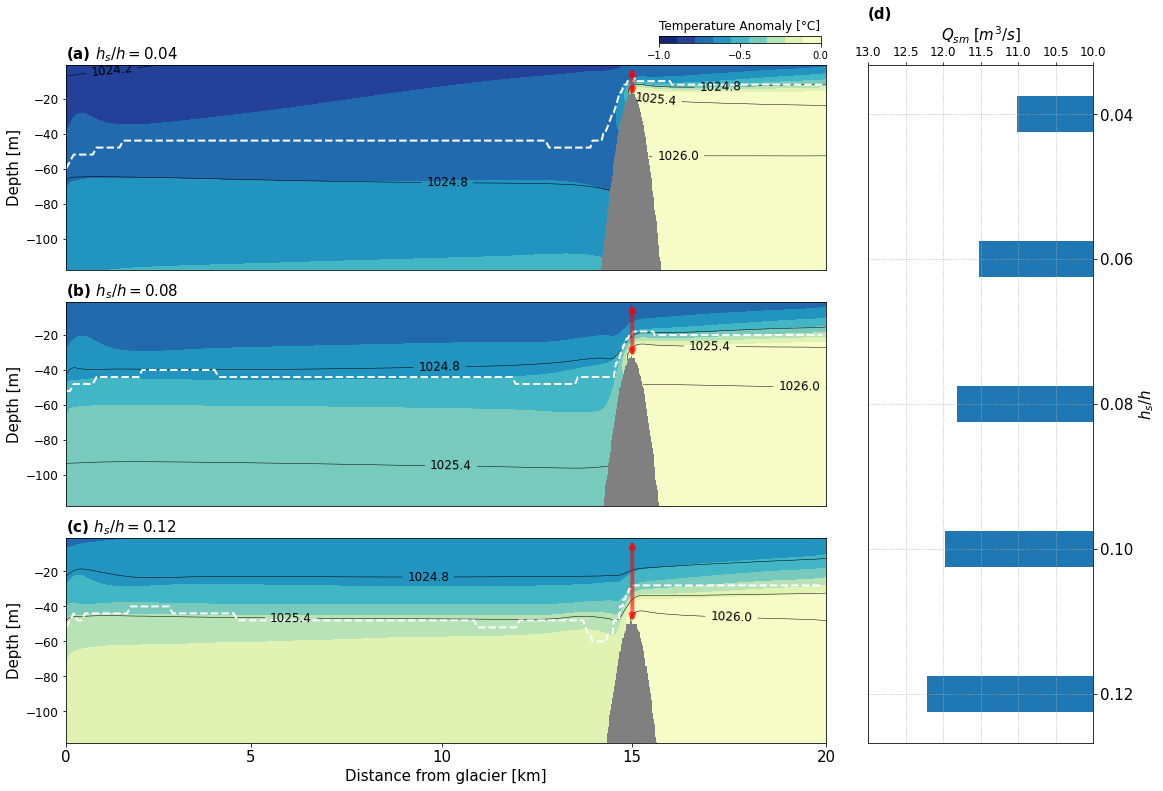

In [7]:
Hs = np.array([1, 2, 3, 4, 5])

Qsm = np.empty(len(Hs))
for i in range(len(Hs)):
    Qsm[i] = IFA(Hs[i])
    
x1, z1, pt1, rho1, h1 = State(Hs[0])
x2, z2, pt2, rho2, h2 = State(Hs[2])
x3, z3, pt3, rho3, h3 = State(Hs[4])


gridsize = (3, 4)
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=3)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=3)
ax3 = plt.subplot2grid(gridsize, (2, 0), colspan=3)
ax4 = plt.subplot2grid(gridsize, (0, 3), colspan=1, rowspan=3)
fig.tight_layout()

ct = np.linspace(-1,0,10) # Contour range for temperature
crho = np.linspace(1020,1026,11) # Contour range for density
cmap = 'YlGnBu_r'

T0 = 9; # initial fjord temperature
zid = 40; # depth index


im1 = ax1.contourf(x1,z1[:zid],pt1[:zid,:]-T0, ct, cmap=cmap)
#current_cmap = matplotlib.cm.get_cmap()
#cmap.set_bad('red',1.)
ax1.xaxis.set_visible(False)
ax1.annotate(text='', xy=(0.745,0.84), xycoords='axes fraction', xytext=(0.745,1), textcoords='axes fraction',arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.6})
ax1.set_xlim([x1[1],x1[-1]])
ax1.set_facecolor('grey')
#ax1.fill_between([x1[0], x1[1]], z1[0], z1[23])

cbaxes = fig.add_axes([0.58, 1.01, 0.15, 0.01])
cbar = fig.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([-1.5,-1,-0.5, 0])
cbar.ax.set_title('Temperature Anomaly [\N{DEGREE SIGN}C]', size=12)
# Plot isopycnals
CS1 = ax1.contour(x1,z1[:zid],rho1[:zid,:],np.linspace(1020,1026,11), colors='k', linewidths=.5)
plt.clabel(CS1, fmt='%1.1f', fontsize=12, inline=1)
ax1.plot(x1[1:-1],-h1, '--w', lw=2)
ax1.set_ylabel('Depth [m]', size=15)
ax1.tick_params(labelsize=12)
ax1.set_title('(a) $h_s/h=0.04$', loc='left', size=15, weight='bold')

im2 = ax2.contourf(x2,z2[:zid],pt2[:zid,:]-T0, ct, cmap=cmap)
ax2.xaxis.set_visible(False)
ax2.annotate(text='', xy=(0.745,0.72), xycoords='axes fraction', xytext=(0.745,1), textcoords='axes fraction', arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.6})
#fig.colorbar(im2,ax=ax2)
CS2 = ax2.contour(x2,z2[:zid],rho2[:zid,:], np.linspace(1020,1026,11), colors='k', linewidths=.5)
plt.clabel(CS2, fmt='%1.1f', fontsize=12, inline=1)
ax2.plot(x2[1:-1],-h2, '--w', lw=2)
ax2.set_ylabel('Depth [m]', size=15)
ax2.tick_params(labelsize=12)
ax2.set_title('(b) $h_s/h=0.08$', loc='left', size=15, weight='bold')
ax2.set_xlim([x2[1],x2[-1]])
ax2.set_facecolor('grey')

im3 = ax3.contourf(x3,z3[:zid],pt3[:zid,:]-T0, ct, cmap=cmap)
#ax3.xaxis.set_visible(False)
ax3.annotate(text='', xy=(0.745,0.58), xycoords='axes fraction', xytext=(0.745,1), textcoords='axes fraction', arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.6})
#fig.colorbar(im3,ax=ax3)
CS3 = ax3.contour(x3,z3[:zid],rho3[:zid,:], np.linspace(1020,1026,11), colors='k', linewidths=.5)
plt.clabel(CS3, fmt='%1.1f', fontsize=12, inline=1)
ax3.plot(x3[1:-1],-h3, '--w', lw=2)
ax3.set_ylabel('Depth [m]', size=15)
ax3.tick_params(labelsize=12)
ax3.set_title('(c) $h_s/h=0.12$', loc='left', size=15, weight='bold')
ax3.set_xlim([x3[1],x3[-1]])
ax3.set_facecolor('grey')
ax3.set_xticks([x3[1], 5, 10, 15, x3[-1]])
ax3.set_xticklabels(["0","5","10","15","20"], size=15)
ax3.set_xlabel('Distance from glacier [km]', size=15)



#ax4.plot(Qsm,[1,2,3,4,5],'o-',lw=3)
#ax4.bar(Qsm, [1,2,3,4,5])
ax4.barh([1,2,3,4,5],Qsm,height=0.25)
ax4.set_xlim([10,13])
#ax4.barh(2+0.25,Qsm[1], height=0.25)

ax4.grid(linestyle=':')
ax4.invert_yaxis()
ax4.invert_xaxis()
ax4.tick_params(labelsize=12)

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_yticks([1, 2, 3, 4, 5])
ax4.set_yticklabels(['0.04','0.06','0.08','0.10','0.12'], size=15)
ax4.set_ylabel(r'$h_s/h$', size=15)

ax4.set_xlabel(r'$Q_{sm}\;[m^3/s]$', size=15, weight='bold')
ax4.xaxis.set_label_position('top')
ax4.xaxis.set_ticks_position('top') # this moves the ticks to the top
ax4.set_title('(d)', loc='left', size=15, weight='bold')


In [5]:
Qsm

array([11.01156281, 11.52797836, 11.8177547 , 11.97337169, 12.21469881])

In [ ]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/BaseCase/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(fig_path + '/Basemap.png', dpi = 200, bbox_inches='tight')    

In [ ]:
fig_path = "/Users/weiyangbao/Dropbox/Manuscripts/Fjord Modeling/Figs/"
fig.savefig(fig_path + '/3_Temp&Qsm.png', dpi = 200, bbox_inches='tight') 

In [9]:
fig_path ="/home/1959/Jupyter_Figs/Qsg500n/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(fig_path + '/Temp&Qsm.png', dpi=200, bbox_inches='tight') 